### TASK 1:  Describe a machine learning problem that you would like to solve using Logistic Regression. Clearly state why Logistic regression is the best choice for solving this problem.

I am going to implement Logistic Regression on a binary classification task for CIFAR-100 Dataset, And I am going to subsample 10-class training set to 2-class training set for Logistic Regression.

Logistic regression is intended for binary (two-class) classification problems because it will predict the probability of an instance belonging to some default class, which can be snapped into a 0 or 1 classification.

In [1]:
import tensorflow as tf
import os
import pickle
import numpy as np
import time
import matplotlib.pyplot as plt

# Plot configurations
%matplotlib inline

In [2]:
import pickle
import os
import tarfile
import urllib.request as url
import numpy as np

def unpickle(file):
    with open(file, 'rb') as fo:
        res = pickle.load(fo, encoding='bytes')
    return res
        
def load_data():
    os.chdir('./')
    meta = unpickle('./data/cifar-100-python/meta')
    coarse_label_names = [t.decode('utf8') for t in meta[b'coarse_label_names']]

    train = unpickle('./data/cifar-100-python//train')
    y_train = np.array(train[b'coarse_labels'])
    X_train = np.array(train[b'data'])

    test = unpickle('./data/cifar-100-python//test')
    y_test = np.array(test[b'coarse_labels'])
    X_test = np.array(test[b'data'])
    
    return coarse_label_names, X_train, y_train, X_test, y_test


### TASK2: Pick a publicly available dataset that you will use to solve this problem. You must provide a link to the dataset and perform necessary Exploratory Data Analysis (EDA).

Load CIFAR-100 data

CIFAR-100 is a widely used dataset which has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs). https://www.cs.toronto.edu/~kriz/cifar.html. 

['aquatic_mammals', 'fish', 'flowers', 'food_containers', 'fruit_and_vegetables', 'household_electrical_devices', 'household_furniture', 'insects', 'large_carnivores', 'large_man-made_outdoor_things', 'large_natural_outdoor_scenes', 'large_omnivores_and_herbivores', 'medium_mammals', 'non-insect_invertebrates', 'people', 'reptiles', 'small_mammals', 'trees', 'vehicles_1', 'vehicles_2']
(50000, 32, 32, 3)


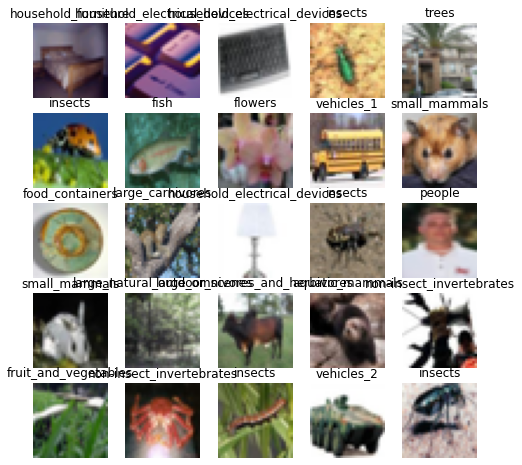

In [32]:
# Load the raw CIFAR-100 data. 
label_map, X_train, y_train, X_test, y_test = load_data()

# I flattened 1×32×32×3 images into 1×3072 Numpy arrays. Number 3 stands for 3 color channels.
# reshape vectorized data into the image format
X = X_train.reshape(50000, 3, 32, 32).transpose(0,2,3,1)

print(label_map)
print(X.shape)

#Visualizing CIFAR 100 data. Randomly choose 25 images from the train dataset to show.
fig, axes1 = plt.subplots(5,5,figsize=(8,8))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(X)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(X[i:i+1][0])
        axes1[j][k].set_title(label_map[y_train[i]])

In [34]:
#    Train data: 49,000 samples from the original train set: indices 1~49,000
#    Validation data: 1,000 samples from the original train set: indices 49,000~50,000
#    Test data: 1,000 samples from the original test set: indices 1~1,000
num_training = 49000
num_validation = 1000
num_test = 1000

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]


X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

X_test = X_test[:num_test, :]
y_test = y_test[:num_test]


# Subsample 10-class training set to 2-class training set
X_train_binary = X_train[y_train<2,:]
num_training_binary = X_train_binary.shape[0]
y_train_binary = y_train[y_train<2]
mask_binary = np.random.choice(num_training_binary, num_dev_binary, replace=False)

X_val_binary = X_val[y_val<2,:]
y_val_binary = y_val[y_val<2]


print('Train data (binary) shape: ', X_train_binary.shape)
print('Train labels (binary) shape: ', y_train_binary.shape)
print('Validation data (binary) shape: ', X_val_binary.shape)
print('Validation labels (binary) shape: ', y_val_binary.shape)



Train data (binary) shape:  (4910, 3072)
Train labels (binary) shape:  (4910,)
Validation data (binary) shape:  (101, 3072)
Validation labels (binary) shape:  (101,)


In [37]:
# Preprocessing: subtract the mean value across every dimension, for binary training data
mean_image = np.mean(X_train_binary, axis=0)

X_train_binary = X_train_binary.astype(np.float32) - mean_image.astype(np.float32)
X_val_binary = X_val_binary.astype(np.float32) - mean_image

X_train_binary = np.hstack([X_train_binary, np.ones((X_train_binary.shape[0], 1))])
X_val_binary = np.hstack([X_val_binary, np.ones((X_val_binary.shape[0], 1))])
print(X_train_binary.shape, X_val_binary.shape)

(4910, 3073) (101, 3073)


### Task 3 : Implement, Logistic Regression in this step. Clearly write your cost function and derivatives before implementing gradient descent. Do not use any built-in packages for this step. You can use the vectorization techniques demonstrated in class. Implement any 2 variants of gradient descent in their original form. (Refer to the research paper discussed in class).

#### Logistic Regression Classifier


Assume a training dataset of images $x_i \in R^D$, each associated with a label $y_i$. Here $i=1 \dots N$ and $y_i \in 1 \dots K$. That is, we have **N** examples (each with a dimensionality **D**) and **K** distinct categories.

Define the score function $f: R^D \to R^K$ that maps the raw image pixels to class scores: $$f(x_i; W, b)=W x_i + b$$
where $W$ is of size $K \times D$ and $b$ is of size $K \times 1$. 

Here I represent the two parameters $W,b$ as one by extending the vector $x_i$ with one additional dimension that always holds the constant **1**. With the extra dimension, the new score function will simplify to a single matrix multiply: $$f = f(x_i;W)=W x_i$$

Logistic regression classifier can solve a binary classification problem. A binary logistic regression calculates the probability of class 1 as:

$$
P(y=1 | x ; w)=\frac{1}{1+e^{-f}}=\sigma\left(f\right)
$$

Since the probabilities of class 1 and 0 sum to one, the probability for class 0 is:

$$
P(y=0 | x ; w)=1-P(y=1 | x ; w)
$$

The loss function then maximizes the log likelihood of this probability:

$$
L_{i}=-\sum_{j} (y_{i j} \log \left(\sigma\left(f_{j}\right)\right)+\left(1-y_{i j}\right) \log \left(1-\sigma\left(f_{j}\right)\right))
$$

where the labels $y_{ij}$ are assumed to be either 1 (positive) or 0 (negative), and $\sigma(\cdot)$ is the sigmoid function. The gradient on $f$ is : 

$$
\frac{\partial L_{i}}{\partial f}=-\sum_{j} (y_{i j}-\sigma\left(f_{j}\right))
$$

$$
\frac{\partial L_{i}}{\partial W}= - \sum_{j} (y_{i j}-\sigma\left(f_{j}\right)) * x_{i}
$$
    

In [71]:
def sigmoid(x):
    h = np.zeros_like(x)
    h = (1.0 / (1.0 + np.exp(-x) ) )
    return h 


class LogisticRegressionClassifier(object):
    def __init__(self):
        self.W = None
        self.velocity = None

    def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
              batch_size=200, optim='SGD', momentum=0.6, verbose=False):
     
        if optim == 'adam':
            b1 = 1
            b2 = 1
            beta_1 = 0.9
            beta_2 = 0.99
            epsilon = 1e-8
            m_t = 0 
            v_t = 0 
            
        num_train, dim = X.shape
        num_classes = np.max(y) + 1  

        # Initialize W and velocity(for SGD with momentum)
        if self.W is None:
            self.W = 0.001 * np.random.randn(dim, num_classes)

        if self.velocity is None:
            self.velocity = np.zeros_like(self.W)

        # Run stochastic gradient descent to optimize W
        loss_history = []
        
        for it in range(num_iters):
        
            index_range = np.random.choice(num_train, batch_size) #generate indices
            X_batch = X[index_range, :]
            y_batch = y[index_range]

        
            # evaluate loss and gradient
            loss, dW = self.loss(X_batch, y_batch, reg)
            loss_history.append(loss)
            
            # Adam: a Method for Stochastic Optimization
            if optim == 'adam':
                b1 *= beta_1
                b2 *= beta_2
                m_t = beta_1*m_t + (1-beta_1)*dW 
                v_t = beta_2*v_t + (1-beta_2)*(dW*dW)
                m_hat = m_t/(1-b1) 
                v_hat = v_t/(1-b2) 

                self.W -= (learning_rate*m_hat)/(np.sqrt(v_hat)+epsilon) 
                
            else:
                self.velocity = momentum * self.velocity + learning_rate * dW
                self.W -= self.velocity

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

        return loss_history

    def predict(self, X):
        return (X @ self.W).argmax(axis = 1)

    
    def loss(self, X, y, reg):

        loss = 0
        dW = np.zeros_like(self.W)


        z = X @ self.W
        h = sigmoid(z)
        m = y.shape[0]
        # calculate loss from fomula
        loss = 1/m*(-y.T @ np.log(h[:,1:2]) - (1 - y).T @ np.log(1 - h[:,1:2])) + reg*np.sum(self.W**2)

        y_2class = np.zeros((m, 2))
        y_2class[:,0], y_2class[:,1] = 1-y, y 
        # calculate dW from fomula
        dW = 1/m*(X.T @ (h - y_2class)) + 2*reg*self.W

        return loss, dW

In [48]:
## Logistic Regression + GD
classifier = LogisticRegressionClassifier()
reg = 1e-5 # regularization
lr = 1e-7 # learning rate
loss_hist_gd = classifier.train(X=X_train_binary, y=y_train_binary, learning_rate=lr,batch_size=X_train_binary.shape[0], momentum = 0, reg=reg, num_iters=1500, optim='GD', verbose=True)

y_train_pred = classifier.predict(X_train_binary)
print('training accuracy: %f' % (np.mean(y_train_binary == y_train_pred), ))
y_val_pred = classifier.predict(X_val_binary)
print('validation accuracy: %f' % (np.mean(y_val_binary == y_val_pred), ))

iteration 0 / 1500: loss 1.733026
iteration 100 / 1500: loss 0.914388
iteration 200 / 1500: loss 0.823396
iteration 300 / 1500: loss 0.799303
iteration 400 / 1500: loss 0.784455
iteration 500 / 1500: loss 0.771699
iteration 600 / 1500: loss 0.754717
iteration 700 / 1500: loss 0.747374
iteration 800 / 1500: loss 0.754098
iteration 900 / 1500: loss 0.745243
iteration 1000 / 1500: loss 0.720576
iteration 1100 / 1500: loss 0.715145
iteration 1200 / 1500: loss 0.720407
iteration 1300 / 1500: loss 0.705904
iteration 1400 / 1500: loss 0.736581
training accuracy: 0.667006
validation accuracy: 0.663366


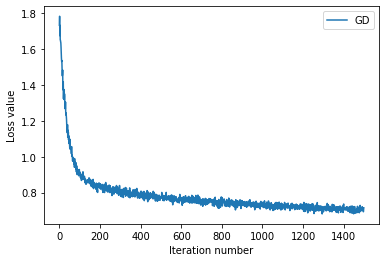

In [75]:
## GD error plot
plt.plot(loss_hist_gd, label='GD')
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.legend()
plt.show()

In [50]:
## Logistic Regression + SGD
classifier = LogisticRegressionClassifier()
reg = 1e-5 
lr = 1e-7 
loss_hist_sgd = classifier.train(X=X_train_binary, y=y_train_binary, learning_rate=lr, reg=reg, momentum = 0, num_iters=1500, optim='SGD', verbose=True)
y_train_pred = classifier.predict(X_train_binary)
print('training accuracy: %f' % (np.mean(y_train_binary == y_train_pred), ))
y_val_pred = classifier.predict(X_val_binary)
print('validation accuracy: %f' % (np.mean(y_val_binary == y_val_pred), ))

iteration 0 / 1500: loss 1.642471
iteration 100 / 1500: loss 1.040035
iteration 200 / 1500: loss 0.929920
iteration 300 / 1500: loss 0.912513
iteration 400 / 1500: loss 0.890649
iteration 500 / 1500: loss 0.775250
iteration 600 / 1500: loss 0.791659
iteration 700 / 1500: loss 0.849824
iteration 800 / 1500: loss 0.730182
iteration 900 / 1500: loss 0.719205
iteration 1000 / 1500: loss 0.764000
iteration 1100 / 1500: loss 0.727144
iteration 1200 / 1500: loss 0.652242
iteration 1300 / 1500: loss 0.600065
iteration 1400 / 1500: loss 0.698300
training accuracy: 0.657230
validation accuracy: 0.643564


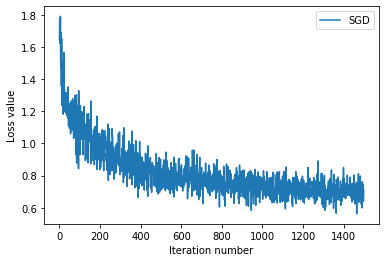

In [51]:
## SGD error plot
plt.plot(loss_hist_sgd, label='SGD')
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.legend()
plt.show()

### Task 4: Pick any 2 optimization algorithms that are used to optimize the ‘vanilla’ gradient descent. Implement both. You may implement these algorithms yourself OR use a package. In your conclusion, compare both optimization techniques/algorithms with respect to the results you achieve. Also compare these results with the original implementation of gradient descent (Task 3 above). Describe why or why not should we use optimization algorithms for the task at hand.

iteration 0 / 1500: loss 1.891377
iteration 100 / 1500: loss 0.783073
iteration 200 / 1500: loss 0.767164
iteration 300 / 1500: loss 0.736201
iteration 400 / 1500: loss 0.697299
iteration 500 / 1500: loss 0.693487
iteration 600 / 1500: loss 0.695907
iteration 700 / 1500: loss 0.671319
iteration 800 / 1500: loss 0.682900
iteration 900 / 1500: loss 0.669393
iteration 1000 / 1500: loss 0.660927
iteration 1100 / 1500: loss 0.655016
iteration 1200 / 1500: loss 0.657490
iteration 1300 / 1500: loss 0.657278
iteration 1400 / 1500: loss 0.625708
iteration 0 / 1500: loss 0.637118
iteration 100 / 1500: loss 0.644250
iteration 200 / 1500: loss 0.633516
iteration 300 / 1500: loss 0.643098
iteration 400 / 1500: loss 0.618358
iteration 500 / 1500: loss 0.630833
iteration 600 / 1500: loss 0.623045
iteration 700 / 1500: loss 0.630052
iteration 800 / 1500: loss 0.626883
iteration 900 / 1500: loss 0.623127
iteration 1000 / 1500: loss 0.618704
iteration 1100 / 1500: loss 0.615343
iteration 1200 / 1500: lo

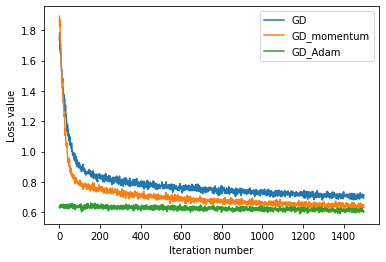

In [74]:
## Logistic Regression + GD + momentum
classifier = LogisticRegressionClassifier()
reg = 1e-5 # regularization
lr = 1e-7 # learning rate
loss_hist_gd_momentum = classifier.train(X=X_train_binary, y=y_train_binary, learning_rate=lr, batch_size=X_train_binary.shape[0], reg=reg, num_iters=1500, optim='GD', verbose=True)
loss_hist_gd_adam = classifier.train(X=X_train_binary, y=y_train_binary, learning_rate=lr, batch_size=X_train_binary.shape[0], reg=reg, num_iters=1500, optim='adam', verbose=True)


## GD error plot
plt.plot(loss_hist_gd, label='GD')
plt.plot(loss_hist_gd_momentum, label='GD_momentum')
plt.plot(loss_hist_gd_adam, label='GD_Adam')

plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.legend()
plt.show()

iteration 0 / 1500: loss 1.013821
iteration 100 / 1500: loss 0.911407
iteration 200 / 1500: loss 0.807000
iteration 300 / 1500: loss 0.736909
iteration 400 / 1500: loss 0.764384
iteration 500 / 1500: loss 0.736366
iteration 600 / 1500: loss 0.740865
iteration 700 / 1500: loss 0.635794
iteration 800 / 1500: loss 0.627984
iteration 900 / 1500: loss 0.753795
iteration 1000 / 1500: loss 0.607257
iteration 1100 / 1500: loss 0.641529
iteration 1200 / 1500: loss 0.637577
iteration 1300 / 1500: loss 0.669713
iteration 1400 / 1500: loss 0.681457
iteration 0 / 1500: loss 0.568691
iteration 100 / 1500: loss 0.695523
iteration 200 / 1500: loss 0.671501
iteration 300 / 1500: loss 0.624963
iteration 400 / 1500: loss 0.703484
iteration 500 / 1500: loss 0.641812
iteration 600 / 1500: loss 0.644526
iteration 700 / 1500: loss 0.600035
iteration 800 / 1500: loss 0.556815
iteration 900 / 1500: loss 0.581162
iteration 1000 / 1500: loss 0.639745
iteration 1100 / 1500: loss 0.593885
iteration 1200 / 1500: lo

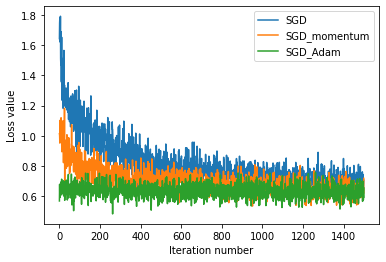

In [73]:
## Logistic Regression + SGD + momentum
classifier = LogisticRegressionClassifier()
reg = 1e-5 
lr = 1e-7 
loss_hist_sgd_momentum = classifier.train(X=X_train_binary, y=y_train_binary, learning_rate=lr, reg=reg, num_iters=1500, optim='SGD', verbose=True)
loss_hist_sgd_Adam = classifier.train(X=X_train_binary, y=y_train_binary, learning_rate=lr, reg=reg, num_iters=1500, optim='adam', verbose=True)


## SGD error plot
plt.plot(loss_hist_sgd, label='SGD')
plt.plot(loss_hist_sgd_momentum, label='SGD_momentum')
plt.plot(loss_hist_sgd_Adam, label='SGD_Adam')


plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.legend()
plt.show()

#### why should we use optimization algorithms for the task ?

Vanilla gradient descent does not guarantee good convergence. Choosing a proper learning rate can be difficult. A learning rate that is too small leads to painfully slow convergence, while a learning rate that is too large can hinder convergence and cause the loss function to fluctuate around the minimum or even to diverge.

Momentum is a method that helps accelerate SGD in the relevant direction and dampens oscillations, Adaptive Moment Estimation (Adam) is another method that computes adaptive learning rates for each parameter. Usually SGD adds randomness to gradient descent, momentum can accelerates the convergence, and adaptive gradient adapts to different learning rate for different parameter.